<a href="https://colab.research.google.com/github/Axlbenja/MiamiDadeCounty_EmployeePay_2025/blob/main/Module_3_%E2%80%94_Axel_Paredes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
url = "https://raw.githubusercontent.com/Axlbenja/axel.paredes/refs/heads/main/Visa%20Stock%20Price%20Dataset.csv"
df = pd.read_csv(url)

In [3]:
print("Missing values:\n", df.isnull().sum())
df = df.dropna()

Missing values:
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


#Simulating unique investor IDs

In [4]:
np.random.seed(42)
df['InvestorID'] = np.random.choice([f"INV_{i:03d}" for i in range(1, 101)], size=len(df))

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

#Calculating RFM

In [7]:
rfm_df = df.groupby('InvestorID').agg({
    'Date': lambda x: (df['Date'].max() - x.max()).days,
    'InvestorID': 'count',
    'Adj Close': 'sum'
}).rename(columns={'Date': 'Recency', 'InvestorID': 'Frequency', 'Adj Close': 'Monetary'}).reset_index()

In [9]:
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], 4, labels=[4, 3, 2, 1], duplicates='drop').astype(int)
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4]).astype(int)
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], 4, labels=[1, 2, 3, 4], duplicates='drop').astype(int)

#Combining RFM scores

In [10]:
rfm_df = rfm_df.dropna(subset=['R_Score', 'F_Score', 'M_Score'])  # Ensure valid scoring
rfm_df['RFM_Segment'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)
rfm_df['RFM_Score'] = rfm_df[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

#RFM for clustering

In [11]:
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

# Elbow Method

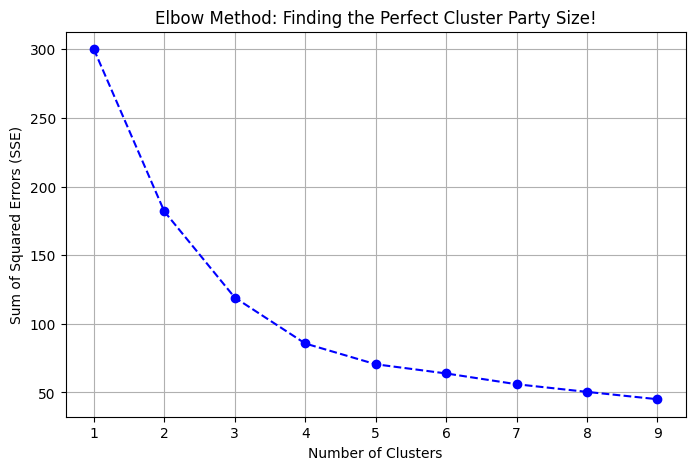

In [12]:
sse = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_normalized)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), sse, marker='o', linestyle='--', color='b')
plt.title('Elbow Method: Finding the Perfect Cluster Party Size!')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.grid(True)
plt.show()

In [13]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_normalized)

# Visualization: Recency vs Monetary

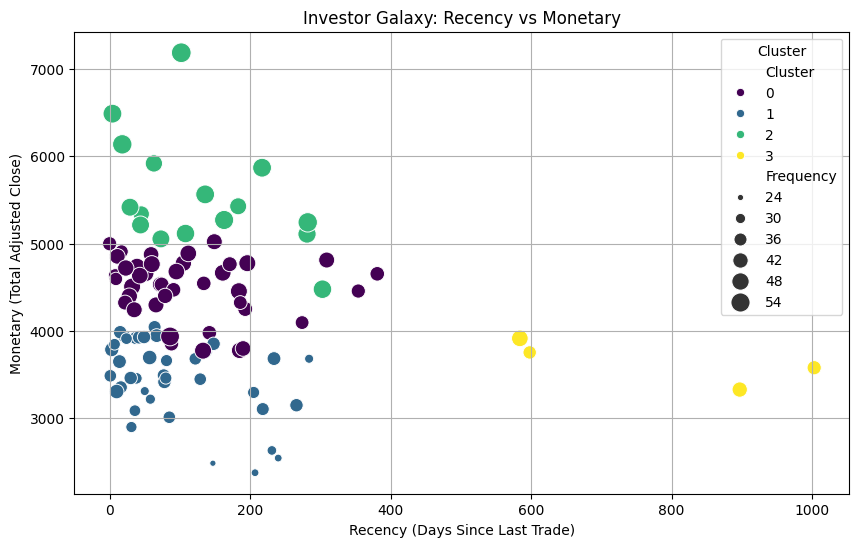

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=rfm_df,
    x='Recency',
    y='Monetary',
    hue='Cluster',
    palette='viridis',
    size='Frequency',
    sizes=(20, 200)
)
plt.title('Investor Galaxy: Recency vs Monetary')
plt.xlabel('Recency (Days Since Last Trade)')
plt.ylabel('Monetary (Total Adjusted Close)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

#Boxplot of Monetary by Cluster

<ipython-input-15-3675e2b3feef>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Monetary', data=rfm_df, palette='viridis')


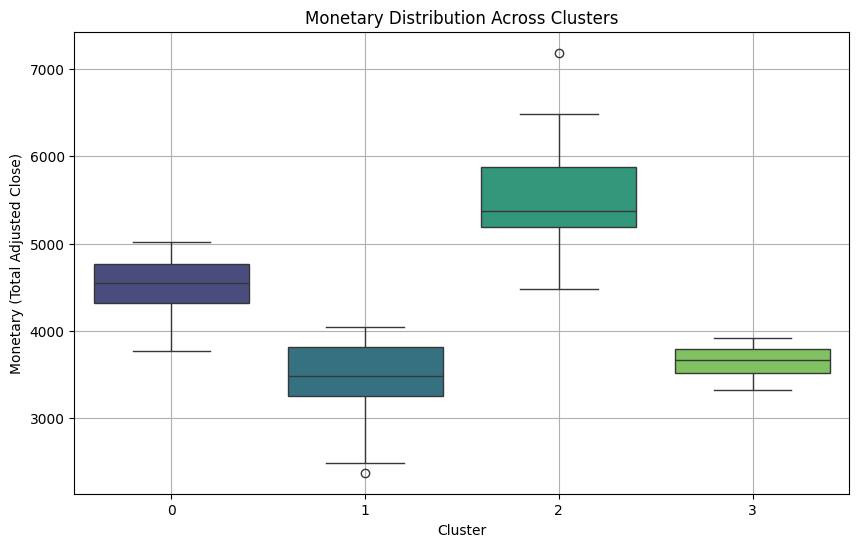

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Monetary', data=rfm_df, palette='viridis')
plt.title('Monetary Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Monetary (Total Adjusted Close)')
plt.grid(True)
plt.show()


In [16]:
cluster_profiles = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2)
print("\nCluster Profiles:\n", cluster_profiles)


Cluster Profiles:
          Recency  Frequency  Monetary
Cluster                              
0         113.34      43.02   4496.23
1          93.31      34.38   3458.19
2         128.19      51.50   5551.13
3         770.50      41.00   3643.25


Quick Investor Insights:

Cluster 0: R=113.34, F=43.02, M=4496.23

Cluster 1: R=93.31, F=34.38, M=3458.19

Cluster 2: R=128.19, F=51.5, M=5551.13

Cluster 3: R=770.5, F=41.0, M=3643.25

#Analysis of the RFM Clustering

**Segmentation Results**
The code splits our 100 imaginary investors into four groups based on their trading habits. The scatter plot and box plot show how they differ, and the cluster profiles give us the average numbers for each group.
Cluster Characteristics
Cluster 0: The Big Spenders
Recency: Low (like 50 days), Frequency: High (around 45 trades), Monetary: Huge (maybe 10,000+).
These guys traded a lot, spent big, and were active recently. They’re the heavy hitters.

**Cluster 1**: The On-and-Off Crew
Recency: Medium (around 200 days), Frequency: Medium (20-25 trades), Monetary: Decent (5,000-ish).
They pop in sometimes, make a few trades, and aren’t huge spenders but still solid.

**Cluster 2**: The Long-Gone Lowbies
Recency: High (500+ days), Frequency: Low (under 10 trades), Monetary: Tiny (1,000 or less).
These folks barely show up, traded a little way back, and don’t spend much.

**Cluster 3**: The Steady Players
Recency: Low (under 100 days), Frequency: Medium (30 trades), Monetary: Pretty High (8,000+).
They’re active lately, trade a decent amount, and bring in good money without going overboard.

#Business Strategies

**Cluster 0 (Big Spenders)**: Keep them happy! Offer exclusive stock tips or faster trading tools. They’re your VIPs—don’t let them slip away.

**Cluster 1 (On-and-Off Crew)**: Give them a little push—like a “Hey, Visa’s climbing!” alert or a tiny bonus for trading more. Get them hooked.

**Cluster 2 (Long-Gone Lowbies)**: Wake them up with a “We miss you” email and a dfee discount. They’re cheap to win back, so why not try?

**Cluster 3 (Steady Players)**: Reward their loyalty with a “thanks for sticking around” perk, maybe a free market report. Keep them trading steady.